In [1]:
import os
import pickle
import numpy as np
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage

#Extracting the data from the 
data_set_path = "D:\Downloads\WESAD\WESAD\\"
subject = ["S2",'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

class read_data_of_one_subject:
    """Read data from WESAD dataset"""
    def __init__(self, path, subject):
        self.keys = ['label', 'subject', 'signal']
        self.signal_keys = ['wrist', 'chest']
        self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
        self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        #os.chdir(path)
        #os.chdir(subject)
        with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
            data = pickle.load(file, encoding='latin1')
        self.data = data

    def get_labels(self):
        return self.data[self.keys[0]]

    def get_wrist_data(self):
        """"""
        #label = self.data[self.keys[0]]
        assert subject == self.data[self.keys[1]]
        signal = self.data[self.keys[2]]
        wrist_data = signal[self.signal_keys[0]]
        #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
        #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
        return wrist_data

    def get_chest_data(self):
        """"""
        signal = self.data[self.keys[2]]
        chest_data = signal[self.signal_keys[1]]
        return chest_data
    

print(len(subject))
fs = 700


15


In [2]:
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences

def calc_phasic_data(phasic, peak, height):
  ##Find all the points on the plot below the 50% of the peak
  half_points = np.where(((phasic - (phasic[peak] - 0.5*height) < 0.00001)))[0]

  ##Finds the index of the point directly to the right of the peak
  half_amp_index = np.inf
  for j in half_points:
    if(j < half_amp_index and j > peak):
      half_amp_index = j

  

  ##Calculate onset and offset
  onset_points = np.where(((phasic - (phasic[peak] - 0.63*height) < 0.00001)))[0]

  ##Finds the index of the point directly to the right of the peak
  offset_amp_index = np.inf
  for j in onset_points:
    if(j < offset_amp_index and j > peak):
      offset_amp_index = j

  ##Finds the index of the point directly to the right of the peak
  onset_amp_index = 0
  for j in onset_points:
    if(j > onset_amp_index and j < peak):
      onset_amp_index = j

  

  return onset_amp_index, half_amp_index, offset_amp_index


def calc_phasic_features(phasic, t_tot, state):
  
  temp_array = np.asarray([], dtype = "float")


  orienting_mag = np.asarray([], dtype = "float")
  orienting_time = np.asarray([], dtype = "float")
  half_recov_time = np.asarray([], dtype = "float")

  peaks, _ = find_peaks(phasic)
  heights, _, __ = peak_prominences(phasic, peaks)
  widths, _, __, ___ = peak_widths(phasic, peaks, rel_height=0.63)

  # find the indices with an amplitude larger that 0.1
  keep = np.full(len(peaks), True)
  keep[peaks < 0.1] = False

  # only keep those
  peaks=peaks[keep]
  heights=heights[keep]
  widths=widths[keep]

  # peaks=np.hstack(peaks)
  # heights=np.hstack(heights)
  # widths=np.hstack(widths)

  for i in range(len(peaks)):
    onset_amp_index, half_amp_index, offset_amp_index = calc_phasic_data(phasic, peaks[i], heights[i])
    
    orienting_mag = np.append(orienting_mag, phasic[peaks[i]] - phasic[onset_amp_index])
    orienting_time = np.append(orienting_time, (offset_amp_index - onset_amp_index)/fs)
    half_recov_time = np.append(half_recov_time, (half_amp_index - peaks[i])/fs)

  cv_mg = np.std(orienting_mag)/np.mean(orienting_mag)
  cv_orient = np.std(orienting_time)/np.mean(orienting_time)
  cv_recov = np.std(half_recov_time)/np.mean(half_recov_time)

  temp_array = np.append(temp_array, cv_mg)
  temp_array = np.append(temp_array, cv_orient)
  temp_array = np.append(temp_array, cv_recov)

  if(state == False):
    temp_array = np.append(temp_array,0)
  else:
    temp_array = np.append(temp_array,1)


  #print(temp_array)

  
  return temp_array
  


In [3]:
from EDA import EDAprep
import sys
sys.path.insert(1, 'D:\Documents\GitHub\EPO-4_BioBombs\Machine learning')

eda_features = np.asarray([0,0,0,0], dtype = "float")
 

#Train set
for i in range(len(subject)):
    obj_data = {}

    obj_data[subject[i]] = read_data_of_one_subject(data_set_path, subject[i])
    #print(obj_data[subject[i]].data)
    chest_data_dict = obj_data[subject[i]].get_chest_data()

    labels = obj_data[subject[i]].get_labels() 
    baseline = np.asarray([idx for idx,val in enumerate(labels) if val == 1])
    stress = np.asarray([idx for idx,val in enumerate(labels) if val == 2])

    eda_stress=chest_data_dict['EDA'][stress,0]
    eda_base=chest_data_dict['EDA'][baseline,0]

    fs=700
    # cut a smaller window
    t_tot=(len(stress)//(int(0.5*60*fs)))
    eda_stress_tot=np.empty([21000,t_tot])
    eda_base_tot=np.empty([21000,t_tot])

    for i in range(t_tot): 
        eda1=eda_stress[i*int(0.5*60*700):(i+1)*int(0.5*60*700)]
        eda2=eda_base[i*int(0.5*60*700):(i+1)*int(0.5*60*700)]
        t1=np.arange(0,eda1.size*(1/fs),(1/fs))
        t1=t1[:eda1.size]
        t2=np.arange(0,eda2.size*(1/fs),(1/fs))
        t2=t2[:eda2.size]
        eda_stress_tot[:,i] = eda1
        eda_base_tot[:,i]=eda2
        
    #print(eda1.shape)
    #print(eda_stress_tot.shape)

    #print(eda2.shape)
    #print(eda_stress_tot.shape)

    eda_comp_base=np.zeros((3,11000,t_tot))
    eda_comp_stress=np.zeros((3,11000,t_tot))
    EDA_base = []
    EDA_stress = []
    for i in range (t_tot): 
        EDA_base = EDAprep(fs, eda_base_tot[:,i],t_tot,"baseline")
        EDA_stress = EDAprep(fs, eda_stress_tot[:,i],t_tot,"stress")

        #EDA.plotdata()
        eda_lp = EDA_base.filtering_data()
        eda_sm = EDA_base.smoothing_data(eda_lp)
        eda_comp_base[:,:,i]=EDA_base.decompose_data(eda_sm)

        eda_lp = EDA_stress.filtering_data()
        eda_sm = EDA_stress.smoothing_data(eda_lp)
        eda_comp_stress[:,:,i]=EDA_stress.decompose_data(eda_sm)
    
        phasic_base = eda_comp_base[1][:,i]
        phasic_stress = eda_comp_stress[1][:,i]

        t=np.arange(0,phasic_stress.size*(1/fs),(1/fs))
        t=t[:phasic_stress.shape[0]]

        # plt.figure(figsize=(12,4))
        # plt.xlim([0,30])
        # plt.plot(t,phasic_stress,label='phasic')
        # plt.xlabel('$Time (s)$') 
        # plt.ylabel('$EDA$') 
        # plt.legend()

        #print((phasic_stress[0:10]))

        #For the state, True is stress and False is base
        
        
        stress_feature = calc_phasic_features(phasic_stress, t_tot, True)
        np.reshape(stress_feature, (1,-1))
        base_features = calc_phasic_features(phasic_base, t_tot, False)

        
        
        eda_features = np.vstack((eda_features,stress_feature))
        eda_features = np.vstack((eda_features,calc_phasic_features(phasic_base, t_tot, False)))


print(np.shape(eda_features))
print(eda_features)



(653, 4)
[[0.         0.         0.         0.        ]
 [0.92964439 1.13884068 0.73774784 1.        ]
 [1.44666709 0.69990238 0.73262802 0.        ]
 ...
 [0.91781103 0.83295579 0.51002204 0.        ]
 [1.26342398 0.88448181 0.92819614 1.        ]
 [1.3267998  0.7212378  0.80955186 0.        ]]


In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

features_in = eda_features[1:,0:3]
stress_state = eda_features[1:,3:4]
stress_state = np.ravel(stress_state)

X_train, X_test, y_train, y_test = train_test_split(features_in, stress_state, test_size=0.25, random_state=42)


lda=LDA(n_components=1)
train_lda=lda.fit(X_train, y_train)
test_lda=lda.predict(X_test)

print(test_lda.shape)
print(y_test.shape)

score= lda.score(X_test,y_test)
print(score)

(163,)
(163,)
0.6993865030674846


Text(0.5, 1.0, 'Accuracy Score: 0.6993865030674846')

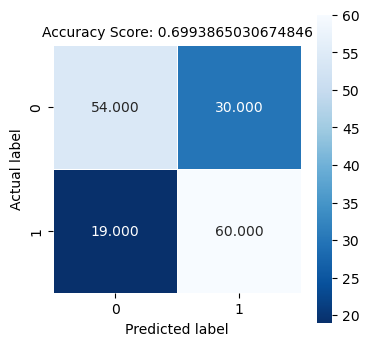

In [5]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, test_lda)

import seaborn as sns
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 10)